In [1]:
from fastai import *
from fastai.vision import *
from fastai.widgets import *
import numpy as np
import matplotlib.pyplot as plt
import torch

In [54]:
folder = 'fire'
file = 'fire.txt'

In [57]:
folder = 'forest'
file = 'forest.txt'

In [58]:
path = Path('data/firedetection')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [59]:
classes = ['fire', 'forest']
download_images(path/file, dest, max_pics=1000)

In [60]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

fire


forest


(['fire', 'forest'], 2, 160, 40)

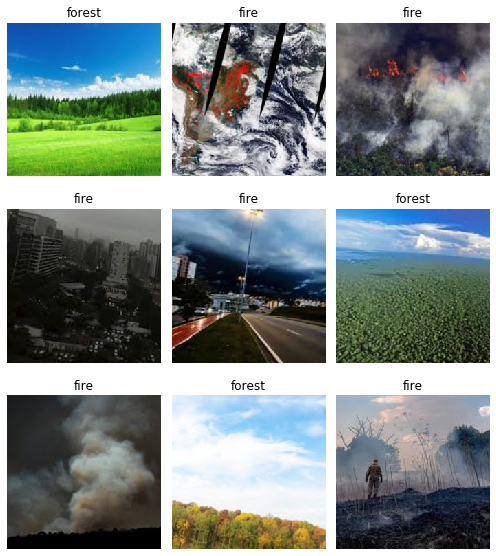

In [61]:
# view the data sets
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)
data.classes
data.show_batch(rows=3, figsize=(7,8))
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

In [62]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(4)
learn.save('stage-1')

epoch,train_loss,valid_loss,error_rate,time
0,1.716706,0.603351,0.275000,00:02
1,1.161679,0.994868,0.225000,00:02
2,0.897347,0.977059,0.150000,00:02
3,0.737683,0.857905,0.125000,00:02


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


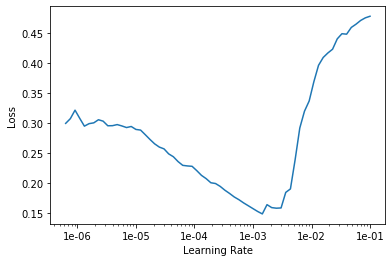

In [63]:
# find a good learning rate
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [64]:
learn.fit_one_cycle(2, max_lr=slice(1e-3))
learn.save('stage-2')

epoch,train_loss,valid_loss,error_rate,time
0,0.199415,0.600474,0.125000,00:02
1,0.182683,0.387224,0.075000,00:02


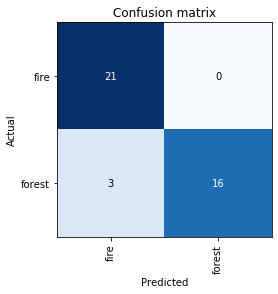

In [65]:
# interpretation
learn.load('stage-2')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [66]:
# clean up
# loss, idxs = interp.top_losses()
# top_loss_paths = data.valid_ds.x[idxs]
# ffd = ImageCleaner(path=top_loss_paths)

In [73]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [74]:
# ds, idxs = DatasetFormatter().from_similars(learn_cln)
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [75]:
ImageCleaner(ds, idxs, path,duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

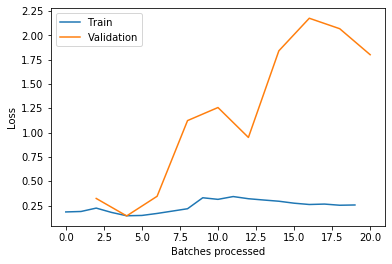

In [79]:
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,error_rate,time
0,0.189492,0.323434,0.075000,00:02
1,0.180028,0.143964,0.100000,00:02
2,0.148772,0.345793,0.125000,00:02
3,0.193466,1.123762,0.150000,00:02
4,0.330560,1.258009,0.100000,00:02
5,0.342997,0.950567,0.100000,00:02
6,0.307420,1.840749,0.100000,00:02
7,0.274786,2.175749,0.175000,00:02
8,0.265638,2.068084,0.150000,00:02
9,0.256421,1.801004,0.100000,00:02


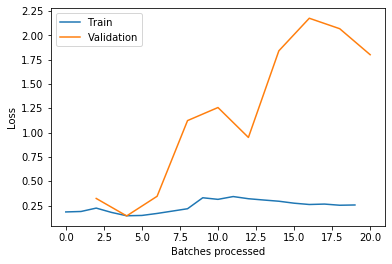

In [77]:
learn.fit_one_cycle(10, max_lr=1e-3)
learn.recorder.plot_losses()

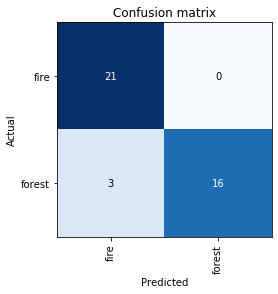

In [78]:
interp.plot_confusion_matrix()

# Linear Regression

tensor([[ 0.6118,  1.0000],
        [ 0.7127,  1.0000],
        [ 0.2799,  1.0000],
        [-0.4085,  1.0000],
        [-0.4248,  1.0000]])
tensor([3., 2.])


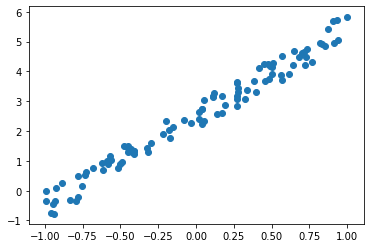

In [115]:
n = 100
x = torch.ones(n, 2)
x[:,0].uniform_(-1, 1)

print(x[:5])
a = tensor(3., 2.)
print(a)
y = x@a + torch.rand(n)
plt.scatter(x[:, 0], y)

In [116]:
# mean squared error
def mse(y_hat, y):
    return ((y_hat-y)**2).mean()

a = tensor(-1., 1)
y_hat = x@a
mse(y_hat, y)

tensor(7.6509)

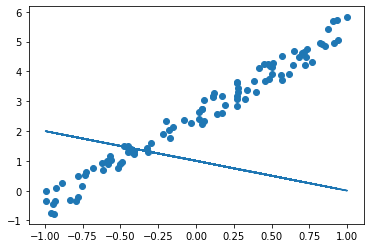

In [117]:
plt.scatter(x[:, 0], y)
plt.plot(x[:, 0], y_hat)

# Gradient Decent

In [118]:
a = nn.Parameter(a); a
def update():
    y_hat = x@a
    loss = mse(y_hat, y)
    if t%10 == 0: print(loss)
    loss.backward()
    with torch.no_grad():
        a.sub_(lr*a.grad)
        a.grad.zero_()
        
lr = 1e-1
for t in range(100): update()

tensor(7.6509, grad_fn=<MeanBackward0>)
tensor(1.3913, grad_fn=<MeanBackward0>)
tensor(0.4009, grad_fn=<MeanBackward0>)
tensor(0.1568, grad_fn=<MeanBackward0>)
tensor(0.0950, grad_fn=<MeanBackward0>)
tensor(0.0793, grad_fn=<MeanBackward0>)
tensor(0.0754, grad_fn=<MeanBackward0>)
tensor(0.0744, grad_fn=<MeanBackward0>)
tensor(0.0741, grad_fn=<MeanBackward0>)
tensor(0.0741, grad_fn=<MeanBackward0>)


Parameter containing:
tensor([2.9343, 2.5205], requires_grad=True)

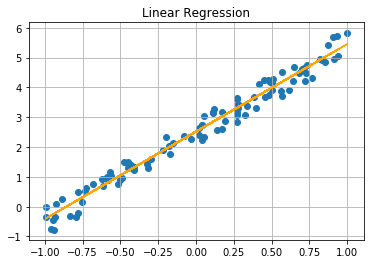

In [121]:
plt.scatter(x[:, 0], y)
plt.plot(x[:, 0], x@a, c='orange')
plt.grid()
plt.title('Linear Regression')
a

# Animate it !

In [129]:
from matplotlib import animation
a = nn.Parameter(tensor(-1., 1))

fig = plt.figure()
plt.scatter(x[:,0], y, c='orange')
line, = plt.plot(x[:,0])
plt.close()

def animate(i):
    update()
    line.set_ydata(x@a)
    return line,

animation.FuncAnimation(fig, animate, np.arange(0, 100), interval=20)